Includes:

In [1]:
import seaborn as sn
import os
import matplotlib.pyplot as plt
from data_paths import get_file_paths_ordered
from pre_process import *
from models import *

Number of speakers and the percentage of the available samples to use to consider:

In [2]:
num_speakers = 8
dataset_percentage = 0.45

Read data:

Total number of speakers in the original dataset: 1251


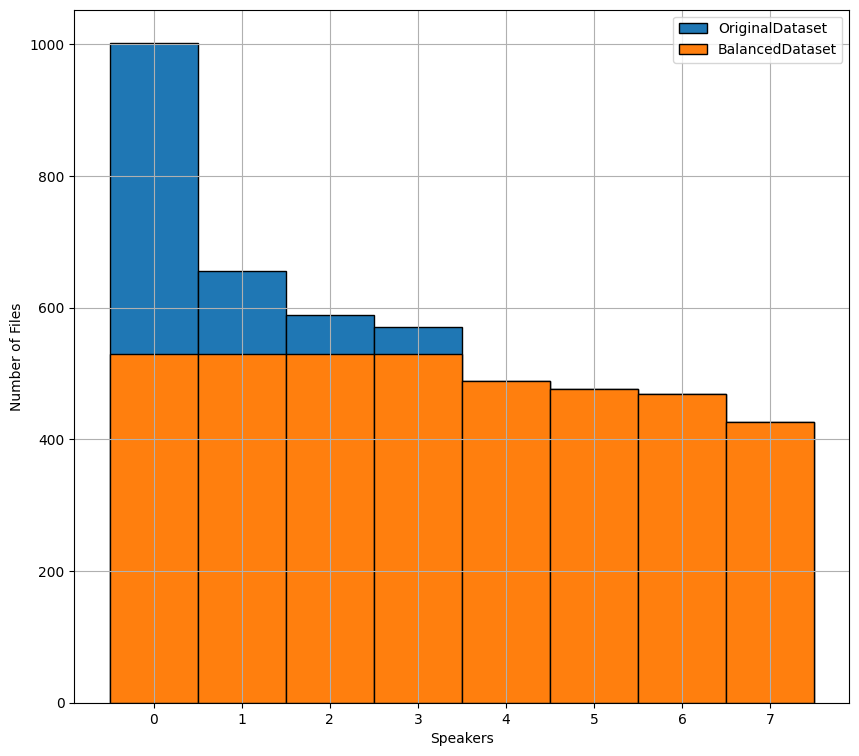

Visualization of the samples ...


100%|██████████| 3975/3975 [00:00<00:00, 11849.07it/s]


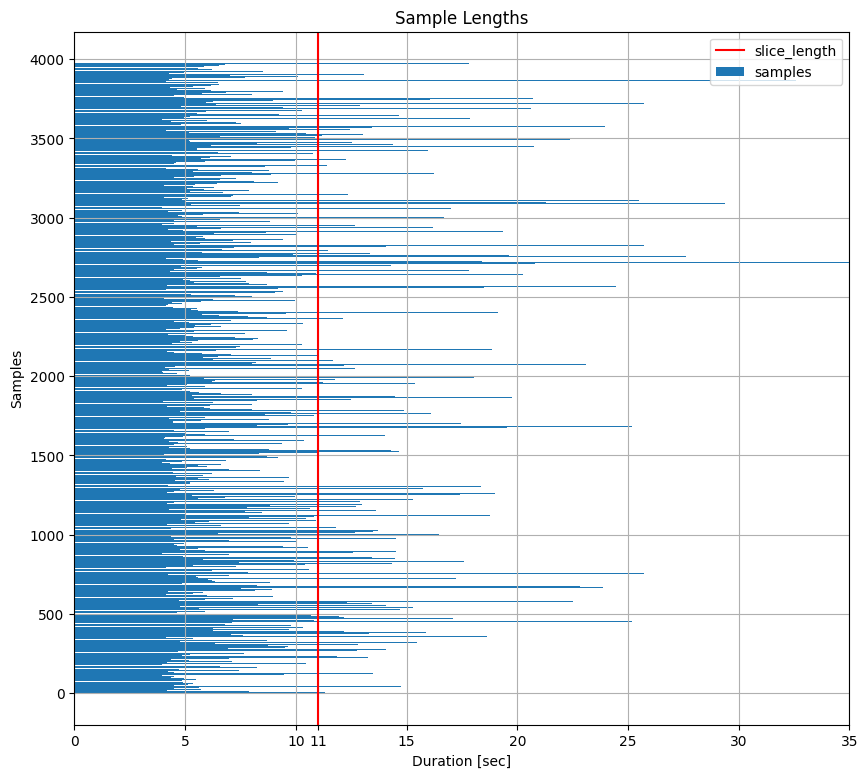

100%|██████████| 357/357 [00:00<00:00, 2718.70it/s]


In [3]:
paths_train, paths_test, y_train_l, y_test_l, all_paths_l  = get_file_paths_ordered(num_speaker=num_speakers, test_ratio=0.2,
                                                                                    balanced_dataset=True, plot_data=True)

seg_len = choose_tot_slice_len(paths=all_paths_l, visualize=True)

x_train, y_train, x_test, y_test = get_data_tensors(paths_train=paths_train, paths_test=paths_test, 
                                                    y_train_l=y_train_l, y_test_l=y_test_l,
                                                    tot_slice_len=seg_len,
                                                    used_train_sz_rat=dataset_percentage, used_test_sz_rat=dataset_percentage)

Pre-Processing:

In [4]:
x_train_mfcc = compute_mfccs(x_train)
x_test_mfcc  = compute_mfccs(x_test)

Define the Model:

In [5]:
input_shape = x_train_mfcc.shape
model = get_model(input_shape=input_shape, nb_classes=num_speakers, model_idx=0)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (1431, 171, 13, 1)       3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (1431, 171, 13, 3)        30        
                                                                 
 batch_normalization (BatchN  (1431, 171, 13, 3)       12        
 ormalization)                                                   
                                                                 
 activation (Activation)     (1431, 171, 13, 3)        0         
                                                                 
 conv2d_1 (Conv2D)           (1431, 86, 7, 16)         448       
                                                                 
 batch_normalization_1 (Batc  (1431, 86, 7, 16)        6

Define learning parameters:

In [6]:
batchSize = 8 # nb of togetherly processed segments(of 1024 samples each) 
epochs = 40 # nb of back propagations

Compile the model and Fit the Data:\
@TODO use weights giving the highest accuracy on the validation dataset

In [7]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
# es = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
# history = model.fit(x=x_train_mfcc, y=y_train, batch_size=batchSize, epochs=epochs, validation_split=0.2, callbacks=[es])
history_keras = model.fit(x=x_train_mfcc, y=y_train, batch_size=batchSize, epochs=epochs)

Epoch 1/40
179/179 [==============================] - 3s 4ms/step - loss: 1.9204 - accuracy: 0.2327
Epoch 2/40
179/179 [==============================] - 1s 4ms/step - loss: 1.6744 - accuracy: 0.3760
Epoch 3/40
179/179 [==============================] - 1s 3ms/step - loss: 1.4442 - accuracy: 0.4752
Epoch 4/40
179/179 [==============================] - 1s 4ms/step - loss: 1.2665 - accuracy: 0.5423
Epoch 5/40
179/179 [==============================] - 1s 4ms/step - loss: 1.0265 - accuracy: 0.6380
Epoch 6/40
179/179 [==============================] - 1s 4ms/step - loss: 0.8239 - accuracy: 0.7233
Epoch 7/40
179/179 [==============================] - 1s 4ms/step - loss: 0.6935 - accuracy: 0.7820
Epoch 8/40
179/179 [==============================] - 1s 4ms/step - loss: 0.5650 - accuracy: 0.8204
Epoch 9/40
179/179 [==============================] - 1s 4ms/step - loss: 0.4673 - accuracy: 0.8435
Epoch 10/40
179/179 [==============================] - 1s 4ms/step - loss: 0.4005 - accuracy: 0.8763

Evaluate the performance on the test set:

In [8]:
y_pred = model.predict(x_test_mfcc)

test_loss, test_acc = model.evaluate(x_test_mfcc,  y_test, verbose=2)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

12/12 [==============================] - 0s 11ms/step
12/12 - 0s - loss: 0.5463 - accuracy: 0.8571 - 140ms/epoch - 12ms/step
Test accuracy: 0.8571428656578064
Test loss: 0.5463365316390991


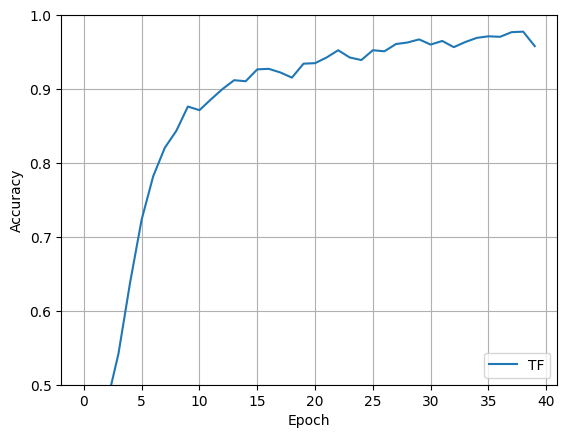

In [9]:
plt.plot(history_keras.history['accuracy'], label='Keras')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.grid()
plt.title("Training Accuracy")
plt.show()

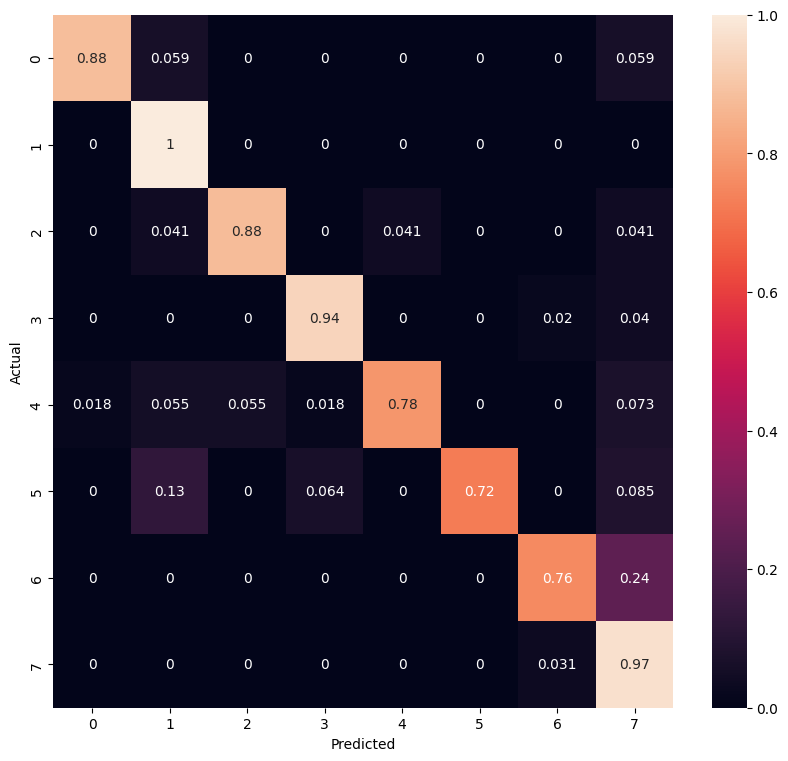

In [10]:
from sklearn.metrics import confusion_matrix

y_pred_hard = np.argmax(y_pred, axis=1)
fig = plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, y_pred_hard, normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

TF Lite Conversion and Quantization: